In [ ]:
pip install kagglehub

In [3]:
import kagglehub   # to download dataset from Kaggle directly
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import EarlyStopping

In [1]:
import kagglehub
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

In [4]:
path

'C:\\Users\\admin\\.cache\\kagglehub\\datasets\\shaunthesheep\\microsoft-catsvsdogs-dataset\\versions\\1'

In [7]:
def find_data_directory(base_path):
    print("Searching for data directory")
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path):
            subdirs = os.listdir(item_path)
            subdirs_lower = [d.lower() for d in subdirs]
            if any("cat" in d for d in subdirs_lower) and any("dog" in d for d in subdirs_lower):
                print(f"Found cat/dog folders in : {item_path}")
    # if not found at top search recursively through all subfolders
    for root, dirs, files in os.walk(base_path):
        dirs_lower = [d.lower() for d in dirs]
        if any("cat" in d for d in dirs_lower) and any("dog" in d for d in dirs_lower):
            print(f"Found cat/dog folders in : {root}")
            return root
    return None

In [8]:
data_dir = find_data_directory(path)
data_dir

Searching for data directory
Found cat/dog folders in : C:\Users\admin\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1\PetImages
Found cat/dog folders in : C:\Users\admin\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1\PetImages


'C:\\Users\\admin\\.cache\\kagglehub\\datasets\\shaunthesheep\\microsoft-catsvsdogs-dataset\\versions\\1\\PetImages'

In [32]:
from PIL import Image

print("Checking for corrupted images...")
num_deleted = 0
for category in ['cat', 'dog']:
    category_dir = [d for d in os.listdir(data_dir) if category in d.lower()][0]
    img_dir = os.path.join(data_dir, category_dir)
    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        try:
            img = Image.open(img_path)
            img.verify()
        except (IOError, SyntaxError):
            os.remove(img_path)  # remove corrupted file
            num_deleted += 1
print(f"Removed {num_deleted} corrupted images")

Checking for corrupted images...
Removed 0 corrupted images


In [35]:
#Define image size and batch size 
IMG_SIZE = 150 #resize all images to 150 x 150
BATCH_SIZE = 32 #number of images processed at once
#Data generators (with augmentation for training)
train_datagen = ImageDataGenerator(
    rescale = 1./255, #normalize pixel values between 0 and 1
    rotation_range = 20, 
    width_shift_range = 0.2, #shift images horizontally
    height_shift_range = 0.2, #randomly shift images vertically
    horizontal_flip = True, #randomly flip images
    validation_split = 0.2
)
train_generator = train_datagen.flow_from_directory(data_dir, 
                                                   target_size = (IMG_SIZE,IMG_SIZE),
                                                   batch_size = BATCH_SIZE, 
                                                   class_mode = 'binary', 
                                                   subset = 'training')

Found 20000 images belonging to 2 classes.


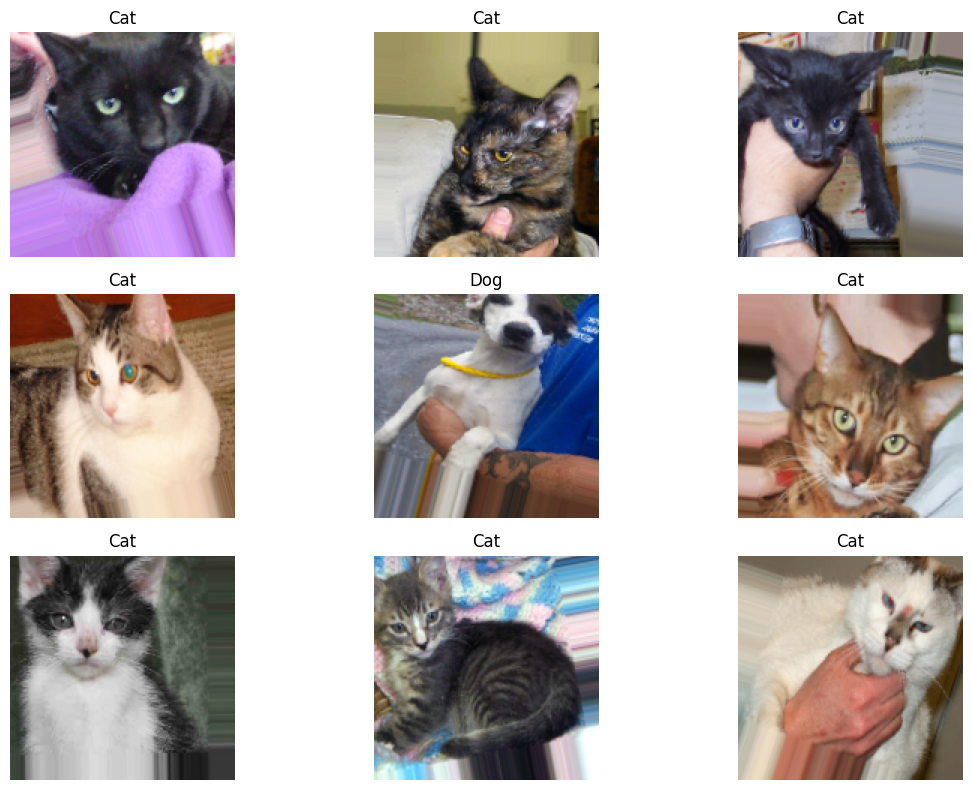

In [36]:
#display some sample images from the dataset
images, labels = next(train_generator)
plt.figure(figsize = (12,8))
for i in range(9): #show first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title("Dog" if  labels[i] == 1 else "Cat")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [37]:
validation_generator = train_datagen.flow_from_directory(
    data_dir, 
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    subset= 'validation'#20% for validation
)

Found 4998 images belonging to 2 classes.


In [38]:
train_generator.samples

20000

In [39]:
validation_generator.samples

4998

In [40]:
model = models.Sequential([
    #First convolutional block
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape =(IMG_SIZE, IMG_SIZE,3)),
    layers.BatchNormalization(), #normalize activations for stability
    layers.MaxPooling2D((2,2)),
    #Second convolutional block 
    layers.Conv2D(64, (3,3), activation = 'relu'),
       layers.BatchNormalization(), #normalize activations for stability
    layers.MaxPooling2D((2,2)),
    #Third convolutional block
      layers.Conv2D(128, (3,3), activation = 'relu'),
       layers.BatchNormalization(), #normalize activations for stability
    layers.MaxPooling2D((2,2)),
    #Flatten feature maps into 1D vector
    layers.GlobalMaxPooling2D(), 
    layers.Dropout(0.5),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.5), 
    layers.Dense(1, activation = 'sigmoid')
])

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.compile(optimizer = 'adam', 
             loss = 'binary_crossentropy', 
             metrics = ['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,425 (497.75 KB)

 Trainable params: 126,977 (496.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
#Callback to stop training when validation loss stops improving

In [44]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights=True)

In [45]:
from PIL import Image

print("Checking for corrupted images...")
num_deleted = 0
for category in ['cat', 'dog']:
    category_dir = [d for d in os.listdir(data_dir) if category in d.lower()][0]
    img_dir = os.path.join(data_dir, category_dir)
    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        try:
            img = Image.open(img_path)
            img.verify()
        except (IOError, SyntaxError):
            os.remove(img_path)  # remove corrupted file
            num_deleted += 1
print(f"Removed {num_deleted} corrupted images")

Checking for corrupted images...
Removed 0 corrupted images


In [46]:
def safe_preprocess(img):
    try:
        return img
    except:
        return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=safe_preprocess
)


In [47]:
batch = next(train_generator)
print("Batch shape:", batch[0].shape, batch[1].shape)

history = model.fit(
    train_generator,
    steps_per_epoch=5,   # only 5 batches
    epochs=1,
    validation_data=validation_generator,
    validation_steps=2
)


Batch shape: (32, 150, 150, 3) (32,)
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4691 - loss: 2.9252 - val_accuracy: 0.5625 - val_loss: 0.6923


In [48]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 496s 793ms/step - accuracy: 0.5207 - loss: 0.9980 - val_accuracy: 0.6078 - val_loss: 0.6843
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 426s 681ms/step - accuracy: 0.5677 - loss: 0.6816 - val_accuracy: 0.5582 - val_loss: 0.6677
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 359s 575ms/step - accuracy: 0.6071 - loss: 0.6616 - val_accuracy: 0.5496 - val_loss: 0.6844
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 363s 580ms/step - accuracy: 0.6331 - loss: 0.6434 - val_accuracy: 0.5758 - val_loss: 0.6471
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 353s 564ms/step - accuracy: 0.6583 - loss: 0.6199 - val_accuracy: 0.6479 - val_loss: 0.6278
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 352s 563ms/step - accuracy: 0.6760 - loss: 0.6038 - val_accuracy: 0.6391 - val_loss: 0.6125
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 353s 564ms/step - accuracy: 0.6920 - loss: 0.5874 - val_accuracy: 0.5402 - val_loss: 0.6822
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 356s 569ms/step - accuracy: 0.7149 -